# Retrieving dust properties with emban

In this tuterial, we aim to retrieve the radial profiles of the dust surface density and dust size from ALMA visibilities of the HD 169142 disk.

In [1]:
import os

os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'
os.environ["OMP_NUM_THREADS"] = '8'

import numpyro
numpyro.set_host_device_count(8)
import sys

sys.path.append('/Users/tomohiroyoshida/emban/emban/')
import emban

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import pickle
import glob

We have two bands: Band 6 and 9. First, load those azimuthally averaged visibilities. It is useful to get them in a dict.

In [2]:
observations = ['HD169142_band3.pkl',  'HD169142_band6.pkl']


loaded_data = {}

data_ids = []

_id = 0

for obs in observations:
    
    data_id = f'data_id_{_id}'
    
    with open(obs, "rb") as f:
        loaded_data[ data_id ] = pickle.load(f)
    
    data_ids.append( data_id )
    
    _id += 1

We have to assume a dust opacity model. Here, we use the DSHARP model. The variable opacity_data will be input to an emban function. This has to be an interpolater that takes the dust proparty (dust size in this example) as inputs.

In [3]:
from scipy.interpolate import interp1d

import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as cst
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io import fits

import dsharp_opac as opacity

c = cst.c.cgs.value
k_B = cst.k_B.cgs.value
h = cst.h.cgs.value

au = cst.au.cgs.value
G = cst.G.cgs.value
M_sun = cst.M_sun.cgs.value

L_sun = cst.L_sun.cgs.value
sigma_sb = cst.sigma_sb.cgs.value
m_p = cst.m_p.cgs.value

d      = np.load(opacity.get_datafile('default_opacities_smooth.npz'))
a      = d['a']
lam    = d['lam']
k_abs  = d['k_abs']
k_sca  = d['k_sca']
gsca   = d['g']

k_sca_eff = (1 - gsca) * k_sca


opacity_data = {}

a_itp = np.logspace( -6, 3, 1000 )


for data_id in data_ids:
    opacity_data[data_id] = {}
    for nch in range(loaded_data[data_id]['Nch']):

        opacity_data[data_id][nch] = {}

        q       = 3.5

        lam_avg = [c/loaded_data[data_id]['nu'][nch]]
        res_eff = opacity.size_average_opacity(lam_avg, a, lam, k_abs, k_sca_eff, q=q, plot=False)

        ka = res_eff['ka'][0]
        ks = res_eff['ks'][0]

        log10_ka_itp = interp1d( np.log10(a), np.log10(ka),bounds_error=False, fill_value = 'extrapolate' )(np.log10(a_itp) )
        log10_ks_itp = interp1d( np.log10(a), np.log10(ks),bounds_error=False, fill_value = 'extrapolate' )(np.log10(a_itp) )


        opacity_data[data_id][nch]['log10_ka'] = log10_ka_itp
        opacity_data[data_id][nch]['log10_ks'] = log10_ks_itp
        opacity_data[data_id][nch]['log10_a'] = jnp.log10(a_itp)



Then, we construct the model. First, let's set the geometry and grids for the gaussian process. Here, r_in and r_out is in arcsec.

In [4]:
diskmodel = emban.model( incl= 13.0,
                       r_in = 0.002, 
                       r_out = 1.2, 
                       N_GP = 120)

In this example, we assume that the temperature profile is known. For such a parameter, we can set a fixed parameter like this. Note that r has to be in arcsec.

In [5]:
diskmodel.set_parameter('T', 
                        free = False, 
                        profile = lambda r: jnp.log10(77*(r/0.117)**(-0.5) ) )

Other parameters, the dust surface density (Sigma_d) and maximum dust size (a_max) are free. Those are sampled from gaussian processes and can be set like this:


In [6]:


diskmodel.set_parameter('Sigma_d', free = True,
                            bounds = ( -4.0, 2.0 ), 
                            g_lengthscale_prior = 0.02)
    
    
diskmodel.set_parameter('a_max', free = True, dust_prop = True,
                            bounds =  ( np.log10(100e-4), 2 ), 
                            g_lengthscale_prior = 0.02)




a_max is input 1 of the dust opacity interpolators.


Finally, we set the observed data by

In [7]:


for data_id in data_ids:
    diskmodel.set_observations( band = data_id,
                                    q = loaded_data[data_id]['q'],
                                    V = loaded_data[data_id]['V'],
                                    s = loaded_data[data_id]['s'],
                                    nu = loaded_data[data_id]['nu'],
                                    Nch = loaded_data[data_id]['Nch'],
                                    s_f = 0.1,
                                    opacity = opacity_data[data_id]
                                   )


Try MAP estimate. You can just run

In [9]:
rng_key= jax.random.PRNGKey(1)
medians, _loss = diskmodel.run_MAP( rng_key, num_iterations = 10000, num_particles = 1, adam_lr = 0.01 )

100%|█| 10000/10000 [00:03<00:00, 2867.16it/s, init loss: 144581949.0353, avg. l


Then check the results.

(1e-05, 1000.0)

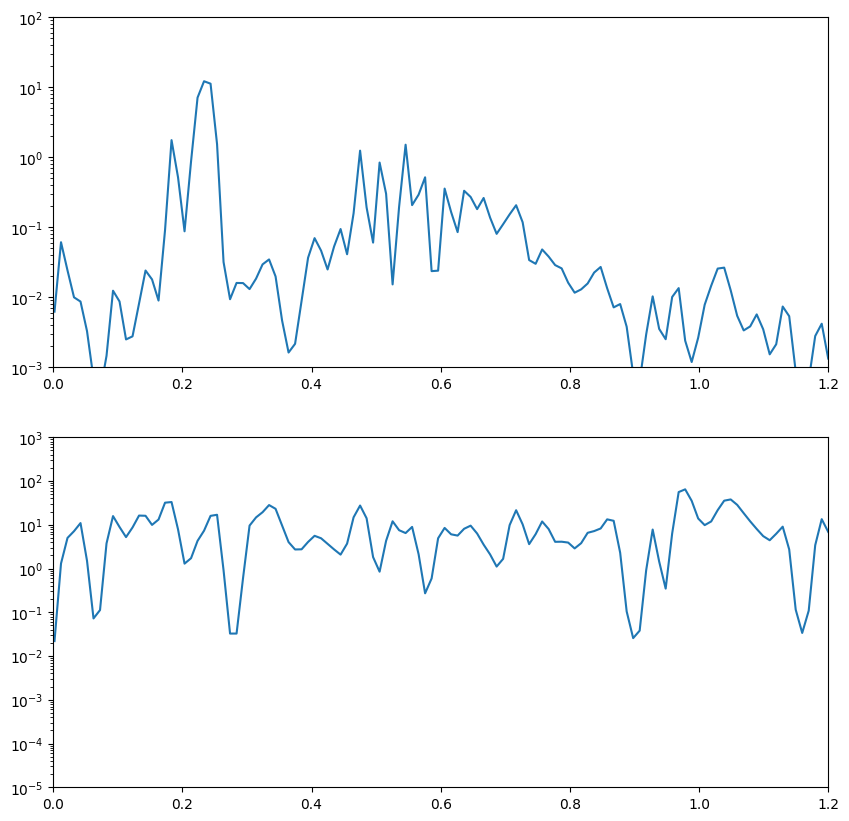

In [18]:
r = diskmodel.r_GP
fig, axes = plt.subplots(2,1, figsize=(10, 10))

axes[0].plot(r, 10**diskmodel.delta_medians['Sigma_d'])

axes[0].set_yscale('log')
axes[0].set_xlim(0, 1.2)
axes[0].set_ylim( 1e-3, 1e2 )



axes[1].plot(r, 10**diskmodel.delta_medians['a_max'])

axes[1].set_yscale('log')
axes[1].set_xlim(0, 1.2)
axes[1].set_ylim( 1e-5, 1e3 )

If you want, you can do MCMC.

In [15]:
rng_key = jax.random.PRNGKey(1)

mcmc_results = diskmodel.run_MCMC( rng_key, steps = 1000,
                                   step_size = 1e-3, num_chains = 4,
                                   medians = medians, max_tree_depth=10 )


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  f_uncert_data_id_0      0.58      0.00      0.58      0.57      0.58     40.99      1.10
  f_uncert_data_id_1      0.60      0.00      0.60      0.59      0.60      9.78      1.23
        g_Sigma_d[0]      0.77      0.04      0.78      0.70      0.84      3.98      1.54
        g_Sigma_d[1]     -0.40      0.31     -0.36     -0.87      0.11      7.94      1.22
        g_Sigma_d[2]     -1.01      0.78     -0.64     -2.28     -0.14      3.25      1.88
        g_Sigma_d[3]     -1.32      1.23     -0.68     -3.27     -0.06      2.94      2.07
        g_Sigma_d[4]     -1.94      1.26     -1.44     -4.16     -0.43      3.21      1.72
        g_Sigma_d[5]     -2.77      1.18     -2.50     -4.88     -1.11      6.01      1.27
        g_Sigma_d[6]     -3.29      1.20     -3.12     -5.22     -1.42     14.31      1.15
        g_Sigma_d[7]     -3.33      1.14     -3.23     -5.10     -1.50     35.01      1.1

Text(0.5, 0, 'r (au)')

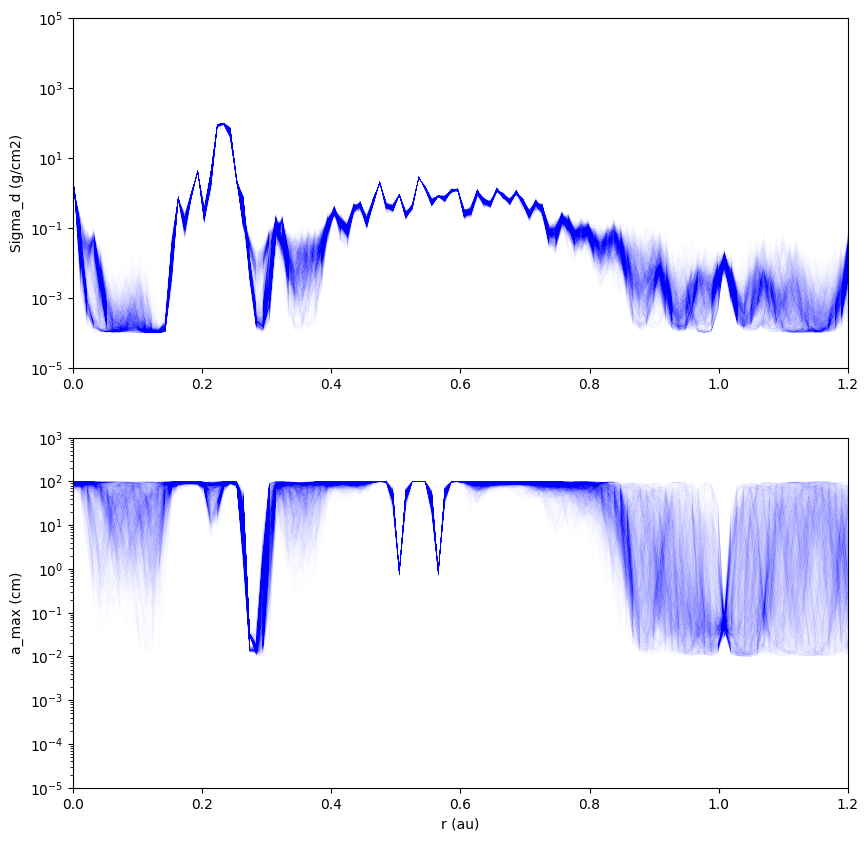

In [20]:

fig, axes = plt.subplots(2,1, figsize=(10, 10))

for _p in mcmc_results['Sigma_d']:
    axes[0].plot( r, 10**_p, alpha=0.02, lw=0.1, color='b' ) 


axes[0].set_yscale('log')
axes[0].set_xlim(0, 1.2)
axes[0].set_ylim( 1e-5, 1e5 )



for _p in mcmc_results['a_max']:
    axes[1].plot( r, 10**_p, alpha=0.02, lw=0.1, color='b' ) 


axes[1].set_yscale('log')
axes[1].set_xlim(0, 1.2)
axes[1].set_ylim( 1e-5, 1e3 )

axes[0].set_ylabel('Sigma_d (g/cm2)')
axes[1].set_ylabel('a_max (cm)')

axes[1].set_xlabel('r (au)')
